# Impedance control of the foot

In [1]:
#setup nice plotting (use widget instead of notebook in the command below if you use jupyter lab)
%matplotlib notebook

# we import useful libraries
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

use_real_robot_computer = False
use_real_robot = False

if use_real_robot_computer:
    from nyu_finger import NYUFingerReal
    from nyu_finger_sim.nyu_finger_simulator import NYUFingerSimulator
else:
    from nyu_finger_simulator import NYUFingerSimulator


import robot_kinematics

## Robot Kinematics
We now consider the complete 3D forward kinematics of the robot as depicted in the following figure. It means that we now take into account $\theta_0$, the sideway motion. In order to do so we need to add a new frame $H_1$ and we rename the hip frame as $H_2$ as it comes after the $\theta_0$ motion in the chain.
We also add a frame at the foot that is oriented like the base frame, we call it $O$ (in dashed line on the picture)
![](./3d_kinematics.png)


## Jacobians of the end-effector
We will also compute the space and body Jacobians of the end-effector. Further, we will compute the Jacobian of the end-effector with respect to the frame O (i.e. the frame attached at the foot but oriented like the space frame)

## The robot_kinematics class
In the package robot_kinematics (in the file __[robot_kinematics.py](./robot_kinematics.py)__ ) we have written functionalities to do the forward kinematics and compute the Jacobians of interest. The code below shows how to use the class, update the kinematics with the current joint angles and retrieve quantities of interest

In [2]:
# example of utilisation of the robot_kinematics class
# you can have access to
# the Space Jacobian => kin.spatialJ
# the Body Jacobian => kin.bodyJ
# the Jacobian in frame O => kin.orientedJ
# the pose of the foot in the S frame => kin.TS_F
# the pose of every other frame in the S frame => kin.TS_H1 / kin.TS_H2 / kin.TS_K

# we create an object
kin = robot_kinematics.robot_kinematics()

# we update the kinematics with some joint angles
q = np.array([0.,0,0])
kin.update_kinematics(q)

# we print the Jacobian from frame O
print("the Jacobian in Frame O is")
print(kin.orientedJ)
print('\n')

# we print the position of the foot
print("The position of the foot in S frame is")
print(kin.TS_F[0:3,3])

the Jacobian in Frame O is
[[ 1.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     1.     1.   ]
 [ 0.     0.32   0.16 ]
 [-0.014  0.     0.   ]
 [-0.32   0.     0.   ]]


The position of the foot in S frame is
[ 0.3   -0.32   0.014]


## Impedance control of the foot

Last laboratory, we used the inverse of the Jacobian to control the foot position and move it in arbitrary directions.
We were inverting the relationship $\dot{p}_{foot} = J \dot{\theta}$ to compute the desired velocity of the joint given a desired velocity of the foot.

In this laboratory, we will revisit direct control of the foot, this time using the relationship $\tau = J^T F_{foot}$, where $\tau$ is the vector of motor torques and $F_{foot}$ the 3D force at the end-effector.
For a desired force $F_{pos}$, we can directly compute the required motor torques $\tau$ without the need to compute
any inverse. We will use this relationship to move the foot.

Assume we want the foot to behave as if springs and dampers were attached to it, as shown in this figure
![](./spring_schematics.png)

Consider the $x$ direction. An ideal spring will have a stiffness $K_x$ and a rest position $x_0$. Therefore, we should see a force pushing or pulling the foot according to $F_x = K_x (x_0 - x_{measured})$, where $x_{measured}$ is the measured position of the foot (make sure that $x_0$ and $x_{measured}$ are expressed in the same coordinate frame!)

In 3D, setting the rest position to $p_0 = [x_0, y_0, z_0]^T \in \mathbb{R}^3$, we will have a force $$F = K (p_0 - p_{measured})$$
where where $p_{measured}$ is the measured position of the foot in 3D and $K$ is a diagonal gain matrix that contains the stiffnesses of the 3 springs one its diagonal, i.e. 
$$K = \begin{bmatrix} K_x & 0 & 0 \\ 0 & K_y & 0 \\ 0 & 0 & K_z \end{bmatrix}$$

To implement this behavior, one can simply set the torques on the motors of the robot as
$$ \tau = J_{Ov}^T K (p_0 - p_{measured})$$ The leg will then behave like a spring.
Note here that we are only using the bottom three rows of the Jacobian, as we are only interested in the force and not the moments (which we ignore).

In addition to a spring, it is often a good idea to have a damper, that will dampen out any oscillations of the spring such that the leg can reach its rest position $p_0$ (otherwise it would oscillate forever). We can then also add a force conteracting velocity of the foot as
$-D \dot{p}_{measured}$, where $D$ is a diagonal matrix that contains the damping gains for each spring.

The resulting controller is then
$$\tau = J_{Ov}^T \Big( K (p_0 - p_{measured}) - D \dot{p}_{measured} \Big)$$

If one wants to track desired setpoint positions (e.g. a trajectory of setpoints) and maybe also a desired velocity,
we can easily adapt the impedance controller as follows
$$\tau = J_{Ov}^T \Big( K (p_{ref}(t) - p_{measured}) + D (\dot{p}_{ref}(t) - \dot{p}_{measured}) \Big)$$
where $p_{ref}(t)$ is a reference trajectory of set points. Note here how this resembles a PD controller in the end-effector space.


## Questions
1. Write an impedance controller with a constant stiffness $K_x = K_z = 50$ and $K_y = 10$ and with damping only in the x,z direction ($D_x = D_z = 5$, $D_y = 0$) so the vertical direction will behave like a ideal spring.
Set $p_0 = [0.3, -0.2, 0.014]$. Plot the position of the end-effector and its velocity as a function of time. Does it behave as expected? (make sure you start the robot with initial configuration $q=[0,0,0]$).
2. Redo the same experiment when adding damping in the y direction $D_y = .1$ and then again with $D_y = 1$. Plot again the end-effector positions and velocities, what do you notice different? (make sure you start the robot with initial configuration $q=[0,0,0]$).
3. Write an impedance controller that can draw a circle in the x-y plane. We would like to follow the 3D foot trajectory $$x_{ref}(t) = \begin{pmatrix} 0.3 + 0.05\cos(\omega t) \\ -0.2 + 0.05 \sin(\omega t) \\ 0 \end{pmatrix}$$
where $\omega = \pi$ is the frequency of rotation around the circle (frequency of rotation of $0.5Hz$).
Use $K = \text{Diag}([50,50,50])$ and $D = \text{Diag}([5,5,5])$. Plot the desired and measured positions of the foot as well as the desired and measured velocities of the foot. Compare your results with what you did in Lab5. What are the pros and cons of both methods?
4. (Optional) Test the controller(s) on the real robot and plot the same plots as for the simulation

In [3]:
# we create a robot simulation
if use_real_robot:
    robot = NYUFingerReal()
    robot.initialize('enp5s0f1')
else:
    robot = NYUFingerSimulator()
    # we reset the simulation to the initial position we want to move
    robot.reset_state(np.array([0.0,0.0,0.1]))

# Q1

In [4]:
# we simulate for 6 seconds
robot.reset_state(np.array([0.0,0.0,0.1]))
run_time = 6.
dt = 0.001
num_steps = int(run_time/dt)

# we create our kinematic object
kin = robot_kinematics.robot_kinematics()

# we create arrays to store information
measured_joint_positions = np.zeros([num_steps,3]) # will store the measured position
measured_joint_velocities = np.zeros_like(measured_joint_positions) # will store the measure velocities

desired_torques = np.zeros_like(measured_joint_positions) # will store the commands we send to the robot

simulation_time = np.zeros([num_steps]) # will store the running time

# we will store the foot positions and velocities
foot_measured_position = np.zeros([num_steps,3])
foot_measured_velocity = np.zeros([num_steps,3])
foot_desired_position = np.zeros([num_steps,3])
foot_desired_velocity = np.zeros([num_steps,3])

K_x = 50
K_y = 10
K_z = 50

K = np.array([[K_x, 0, 0],
              [0, K_y, 0],
              [0, 0, K_z]])

D_x = 5
D_y = 0
D_z = 5

D = np.array([[D_x, 0, 0],
              [0, D_y, 0],
              [0, 0, D_z]])

p_0 = np.array([[0.3],[-0.2],[0.014]])

q = np.array([[0],[0],[0]])

# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i
    
    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    measured_joint_positions[i,:] = q
    measured_joint_velocities[i,:] = dq
        
    foot_desired_position[i,:] = np.reshape(p_0, (1,3))
    
    # save the current position of the foot using the FK function    
    kin.update_kinematics(q)
    foot_measured_position[i,:] = kin.TS_F[0:3,3]

    jacobian = kin.orientedJ[3:6,:]    
    foot_measured_velocity[i,:] = jacobian.dot(dq)

     ###WRITE THE CONTROLLER HERE
    joint_torques = np.array([0,0,0])
    
    joint_torques = np.transpose(jacobian)@((K@(p_0-np.reshape(foot_measured_position[i],(3, 1)))) - (D@np.reshape(foot_measured_velocity[i],(3, 1))))
    
    desired_torques[i,:] = np.reshape(joint_torques,(1, 3))
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


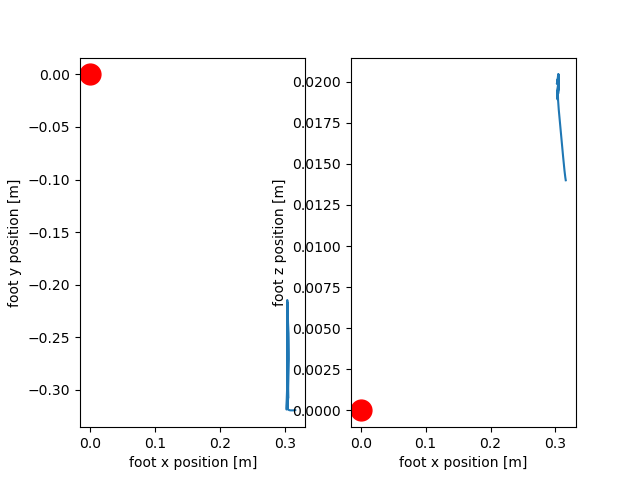

<IPython.core.display.Javascript object>


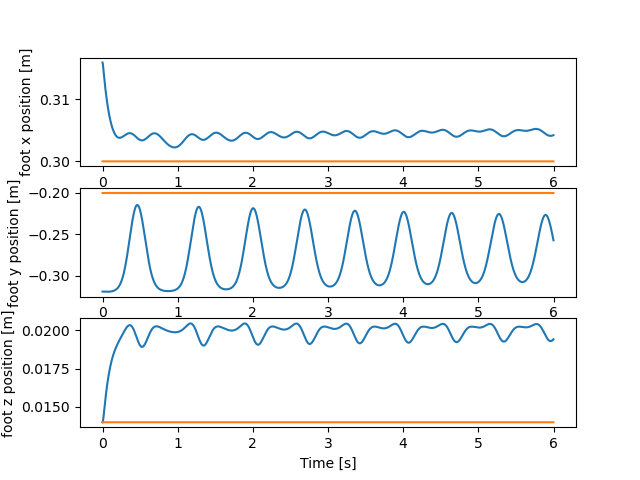

<IPython.core.display.Javascript object>


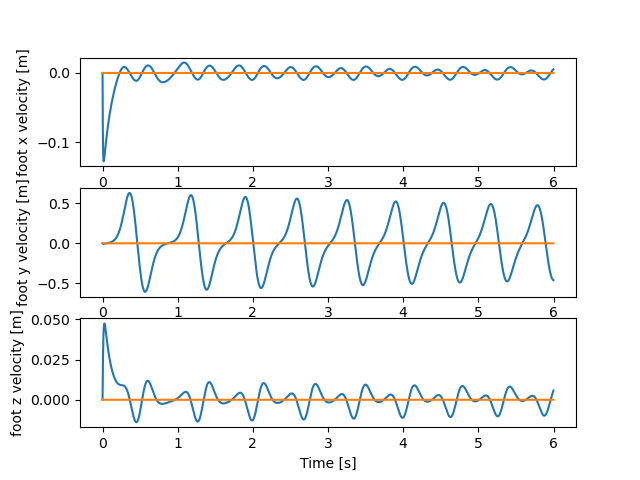

In [5]:
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

def plot_foot_trajectory(time, foot_pos, foot_pos_des, foot_vel, foot_vel_des):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """    
    x_pos = foot_pos[:,0]
    y_pos = foot_pos[:,1]
    z_pos = foot_pos[:,2]
    
    x_vel = foot_vel[:,0]
    y_vel = foot_vel[:,1]
    z_vel = foot_vel[:,2]
    
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.plot(x_pos,y_pos)
    plt.plot(foot_pos_des[:,0], foot_pos_des[:,1])
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    plt.subplot(1,2,2)
    plt.plot(x_pos,z_pos)
    plt.plot(foot_pos_des[:,0], foot_pos_des[:,2])
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot z position [m]')
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time, x_pos, time, foot_pos_des[:,0])
    plt.ylabel('foot x position [m]')
    plt.subplot(3,1,2)
    plt.plot(time, y_pos, time, foot_pos_des[:,1])
    plt.ylabel('foot y position [m]')
    plt.subplot(3,1,3)
    plt.plot(time, z_pos, time, foot_pos_des[:,2])
    plt.ylabel('foot z position [m]')
    plt.xlabel('Time [s]')
    
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time, x_vel, time, foot_vel_des[:,0])
    plt.ylabel('foot x velocity [m]')
    plt.subplot(3,1,2)
    plt.plot(time, y_vel, time, foot_vel_des[:,1])
    plt.ylabel('foot y velocity [m]')
    plt.subplot(3,1,3)
    plt.plot(time, z_vel, time, foot_vel_des[:,2])
    plt.ylabel('foot z velocity [m]')
    plt.xlabel('Time [s]')

plot_foot_trajectory(simulation_time, foot_measured_position, foot_desired_position, foot_measured_velocity, foot_desired_velocity)

# Ans 1
1. Yes it behaves as expected. It acts like a spring the continues to bounce with a slowly decreasing amplitude,mainly due to friction and gravity, not damping.

# Q2 - Dy = 0.1

In [6]:
# we simulate for 6 seconds
robot.reset_state(np.array([0.0,0.0,0.1]))
run_time = 6.
dt = 0.001
num_steps = int(run_time/dt)

# we create our kinematic object
kin = robot_kinematics.robot_kinematics()

# we create arrays to store information
measured_joint_positions = np.zeros([num_steps,3]) # will store the measured position
measured_joint_velocities = np.zeros_like(measured_joint_positions) # will store the measure velocities

desired_torques = np.zeros_like(measured_joint_positions) # will store the commands we send to the robot

simulation_time = np.zeros([num_steps]) # will store the running time

# we will store the foot positions and velocities
foot_measured_position = np.zeros([num_steps,3])
foot_measured_velocity = np.zeros([num_steps,3])
foot_desired_position = np.zeros([num_steps,3])
foot_desired_velocity = np.zeros([num_steps,3])

K_x = 50
K_y = 10
K_z = 50

K = np.array([[K_x, 0, 0],
              [0, K_y, 0],
              [0, 0, K_z]])

D_x = 5
D_y = 0.1
D_z = 5

D = np.array([[D_x, 0, 0],
              [0, D_y, 0],
              [0, 0, D_z]])

p_0 = np.array([[0.3],[-0.2],[0.014]])

q = np.array([[0],[0],[0]])

# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i
    
    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    measured_joint_positions[i,:] = q
    measured_joint_velocities[i,:] = dq
    
    foot_desired_position[i,:] = np.reshape(p_0, (1,3))

        
    # save the current position of the foot using the FK function    
    kin.update_kinematics(q)
    foot_measured_position[i,:] = kin.TS_F[0:3,3]

    jacobian = kin.orientedJ[3:6,:]    
    foot_measured_velocity[i,:] = jacobian.dot(dq)

     ###WRITE THE CONTROLLER HERE
    joint_torques = np.array([0,0,0])
    
    joint_torques = np.transpose(jacobian)@((K@(p_0-np.reshape(foot_measured_position[i],(3, 1)))) - (D@np.reshape(foot_measured_velocity[i],(3, 1))))
    
    desired_torques[i,:] = np.reshape(joint_torques,(1, 3))
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


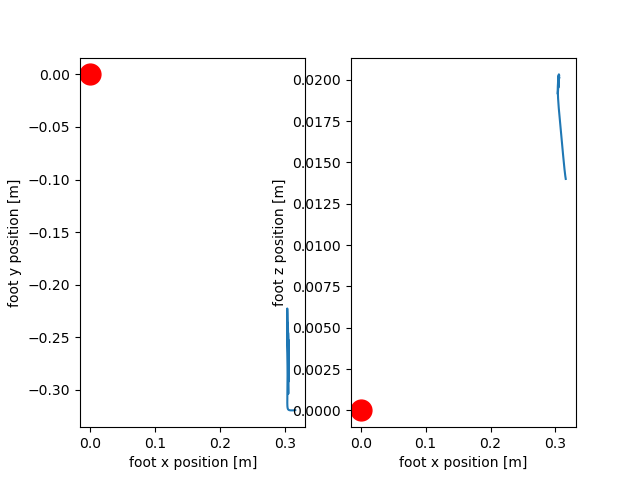

<IPython.core.display.Javascript object>


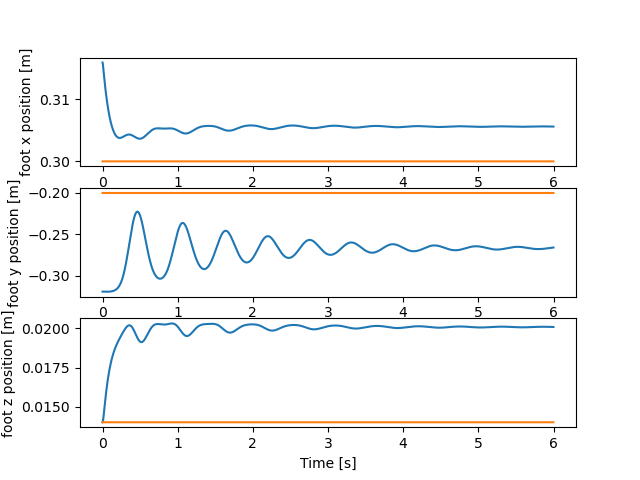

<IPython.core.display.Javascript object>


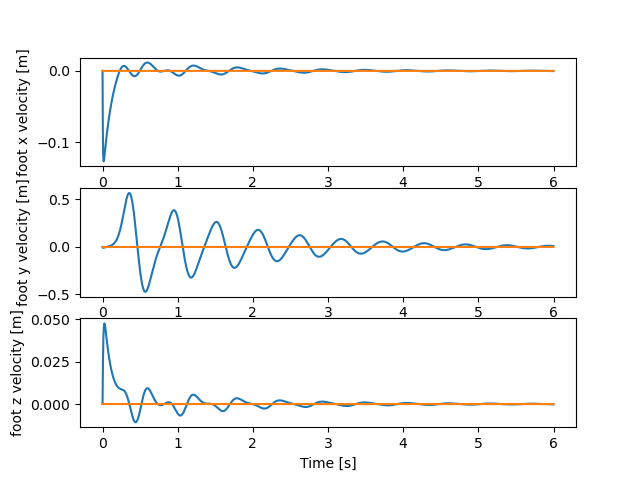

In [7]:
plot_foot_trajectory(simulation_time, foot_measured_position, foot_desired_position, foot_measured_velocity, foot_desired_velocity)

# Ans 2 - Dy = 0.1
1. Yes it behaves as expected. It acts like a spring the continues to bounce with a gradually decreasing amplitude, mainly due to damping.

# Q2 - Dy = 1.0

In [8]:
# we simulate for 6 seconds
robot.reset_state(np.array([0.0,0.0,0.1]))
run_time = 6.
dt = 0.001
num_steps = int(run_time/dt)

# we create our kinematic object
kin = robot_kinematics.robot_kinematics()

# we create arrays to store information
measured_joint_positions = np.zeros([num_steps,3]) # will store the measured position
measured_joint_velocities = np.zeros_like(measured_joint_positions) # will store the measure velocities

desired_torques = np.zeros_like(measured_joint_positions) # will store the commands we send to the robot

simulation_time = np.zeros([num_steps]) # will store the running time

# we will store the foot positions and velocities
foot_measured_position = np.zeros([num_steps,3])
foot_measured_velocity = np.zeros([num_steps,3])
foot_desired_position = np.zeros([num_steps,3])
foot_desired_velocity = np.zeros([num_steps,3])

K_x = 50
K_y = 10
K_z = 50

K = np.array([[K_x, 0, 0],
              [0, K_y, 0],
              [0, 0, K_z]])

D_x = 5
D_y = 1
D_z = 5

D = np.array([[D_x, 0, 0],
              [0, D_y, 0],
              [0, 0, D_z]])

p_0 = np.array([[0.3],[-0.2],[0.014]])

q = np.array([[0],[0],[0]])

# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i
    
    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    measured_joint_positions[i,:] = q
    measured_joint_velocities[i,:] = dq
    
    foot_desired_position[i,:] = np.reshape(p_0, (1,3))
    
    # save the current position of the foot using the FK function    
    kin.update_kinematics(q)
    foot_measured_position[i,:] = kin.TS_F[0:3,3]

    jacobian = kin.orientedJ[3:6,:]    
    foot_measured_velocity[i,:] = jacobian.dot(dq)

     ###WRITE THE CONTROLLER HERE
    joint_torques = np.array([0,0,0])
    
    joint_torques = np.transpose(jacobian)@((K@(p_0-np.reshape(foot_measured_position[i],(3, 1)))) - (D@np.reshape(foot_measured_velocity[i],(3, 1))))
    
    desired_torques[i,:] = np.reshape(joint_torques,(1, 3))
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


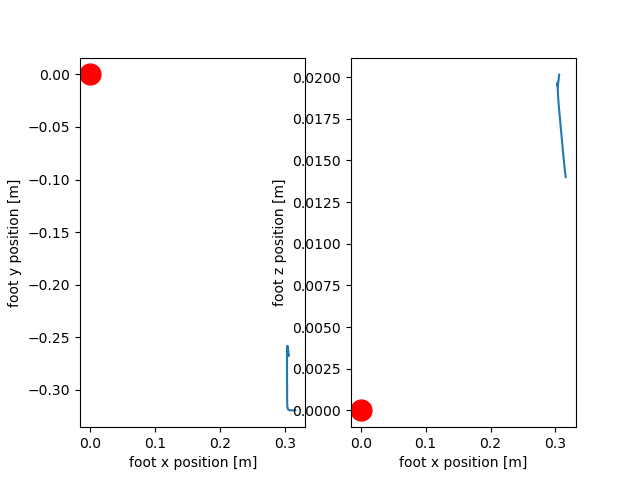

<IPython.core.display.Javascript object>


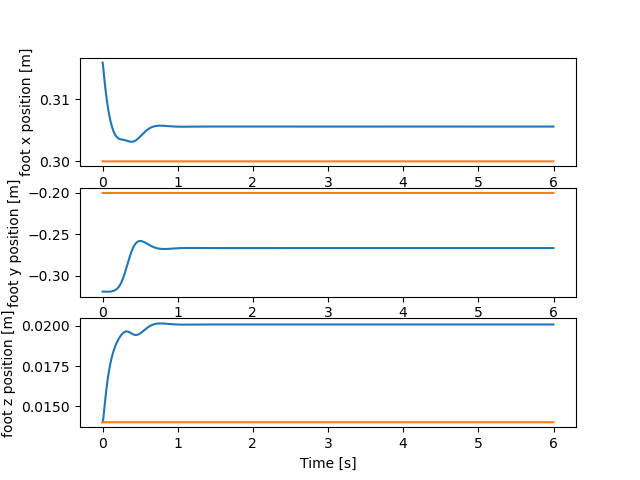

<IPython.core.display.Javascript object>


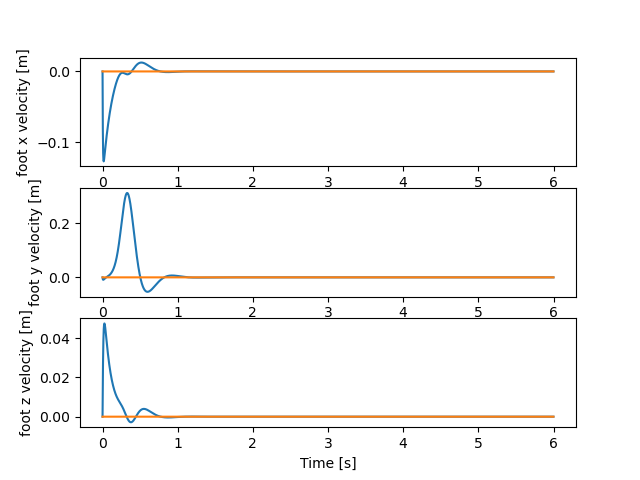

In [9]:
plot_foot_trajectory(simulation_time, foot_measured_position, foot_desired_position, foot_measured_velocity, foot_desired_velocity)

# Ans 2 - Dy = 1.0
1. Yes it behaves as expected. It almosts comes to a instant standstill, mainly due to high damping.

# Q3

In [10]:
# we simulate for 6 seconds
robot.reset_state(np.array([0.0,0.0,0.1]))
run_time = 6.
dt = 0.001
num_steps = int(run_time/dt)

# we create our kinematic object
kin = robot_kinematics.robot_kinematics()

# we create arrays to store information
measured_joint_positions = np.zeros([num_steps,3]) # will store the measured position
measured_joint_velocities = np.zeros_like(measured_joint_positions) # will store the measure velocities

desired_torques = np.zeros_like(measured_joint_positions) # will store the commands we send to the robot

simulation_time = np.zeros([num_steps]) # will store the running time

# we will store the foot positions and velocities
foot_measured_position = np.zeros([num_steps,3])
foot_measured_velocity = np.zeros([num_steps,3])
foot_desired_position = np.zeros([num_steps,3])
foot_desired_velocity = np.zeros([num_steps,3])

K_x = 50
K_y = 50
K_z = 50

K = np.array([[K_x, 0, 0],
              [0, K_y, 0],
              [0, 0, K_z]])

D_x = 5
D_y = 5
D_z = 5

D = np.array([[D_x, 0, 0],
              [0, D_y, 0],
              [0, 0, D_z]])

p_0 = np.array([[0.3],[-0.2],[0.014]])

q = np.array([[0],[0],[0]])

# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i
    
    # we get the position and velocities of the joints and save them
    q, dq = robot.get_state()
    measured_joint_positions[i,:] = q
    measured_joint_velocities[i,:] = dq
        
    # save the current position of the foot using the FK function    
    kin.update_kinematics(q)
    foot_measured_position[i,:] = kin.TS_F[0:3,3]

    jacobian = kin.orientedJ[3:6,:]    
    foot_measured_velocity[i,:] = jacobian.dot(dq)

    x_ref = np.array([[0.3 + 0.05*np.cos(np.pi*simulation_time[i])],[-0.2 +0.05*np.sin(np.pi*simulation_time[i])],[0.]])
    x_ref_tdev = np.array([[0.05*np.pi*-1*np.sin(np.pi*simulation_time[i])],[0.05*np.pi*np.cos(np.pi*simulation_time[i])],[0.]])

    foot_desired_position[i,:] = np.reshape(x_ref, (1,3))
    foot_desired_velocity[i,:] = np.reshape(x_ref_tdev, (1,3))
    
     ###WRITE THE CONTROLLER HERE
    joint_torques = np.array([0,0,0])
    
    joint_torques = np.transpose(jacobian)@((K@(x_ref-np.reshape(foot_measured_position[i],(3, 1)))) + (D@(x_ref_tdev - np.reshape(foot_measured_velocity[i],(3, 1)))))
    
    desired_torques[i,:] = np.reshape(joint_torques,(1, 3))
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


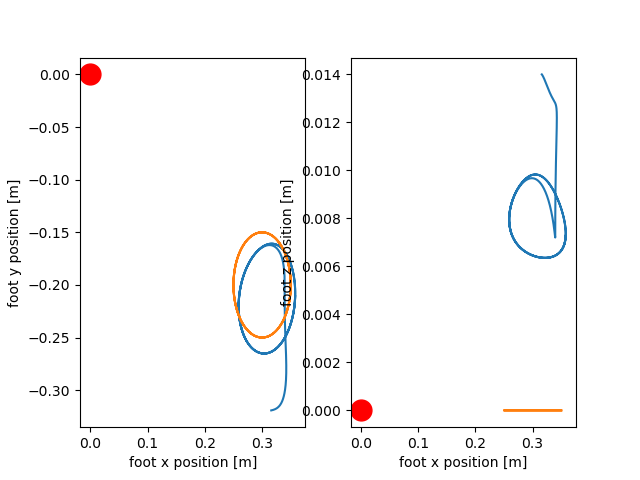

<IPython.core.display.Javascript object>


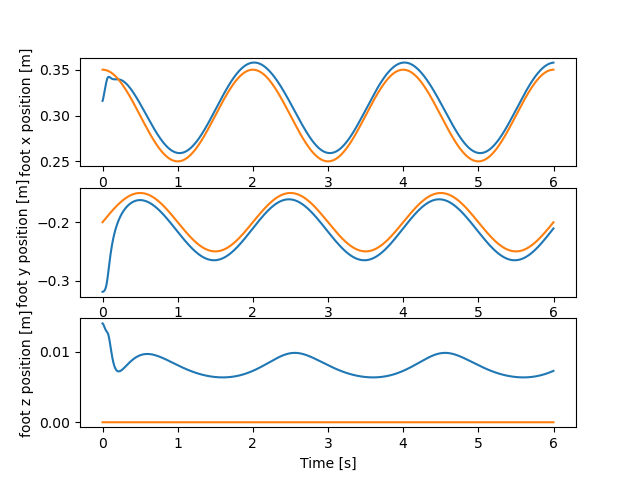

<IPython.core.display.Javascript object>


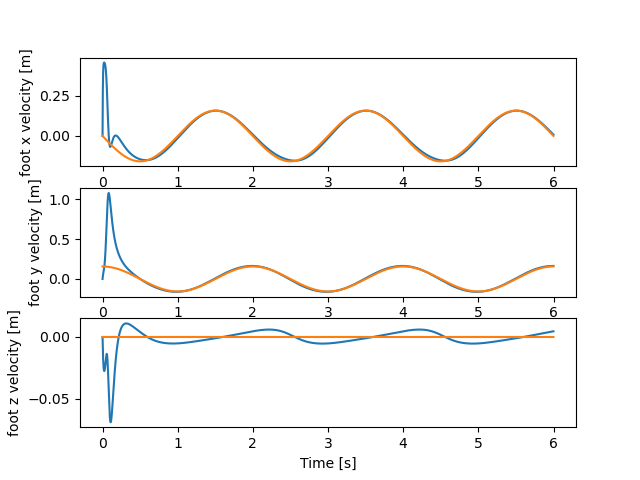

In [11]:
plot_foot_trajectory(simulation_time, foot_measured_position, foot_desired_position, foot_measured_velocity, foot_desired_velocity)

# Ans 3
1. The position of the foot is in the x-axis is more accurate, in Lab 6 than it was in lab 5.

